# Speedrun Efficiency Analysis

### Game Selection

In [1]:
# Selecting the game
game_name = 'elden_ring'

### Import Libraries

In [2]:
import os
import time
import json
import datetime as dt
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
import pwlf
from sklearn.utils import resample

### Defining variables for API GET statenent

In [3]:
# Getting the game ID
base_url = 'https://www.speedrun.com/api/v1'

response = requests.get(f'{base_url}/games?name={game_name}')
data = response.json()

In [4]:
# Define the status, platform, order, direction, and max results
status = 'verified'
platform = '8gej2n93'  # Platform == PC
orderby = 'date'
direction = 'asc'
max_results = 200  # Maximum results per page

### Defining Functions

#### Grabbing the Game ID

In [5]:
def get_game_id(game_name):
    response = requests.get(f'{base_url}/games?name={game_name}')
    data = response.json()
    if response.status_code == 200:
        return data['data'][0]['id']
    else:
        return None

#### Getting the categories for the game

In [6]:
def get_categories(game_id):
    response = requests.get(f'{base_url}/games/{game_id}/categories')
    if response.status_code == 200:
        data = response.json()
        categories = {}
        for category in data['data']:
            # Get the category type ('per-level' or 'full-game')
            category_type = category['type']
            # Store the category name and type in the dictionary
            categories[category['id']] = {'name': category['name'], 'type': category_type}
        return categories
    else:
        print(f'Request failed with status code {response.status_code}.')
        return None

#### Getting the runs for the game

In [7]:
def get_runs_for_category(game_id, category_id, category_name, category_type):
    extracted_data = []
    page = 0
    while True:
        offset = page * max_results
        response = requests.get(f'{base_url}/runs?game={game_id}&category={category_id}&status={status}&platform={platform}&orderby={orderby}&direction={direction}&max={max_results}&offset={offset}')
        if response.status_code == 200:
            data = response.json()
            if not data['data']:
                break
            for run in data['data']:
                date = run['date']
                submitted = run['submitted']
                verified = run['status']['status']
                primary_t = run['times']['primary_t']
                realtime_t = run['times']['realtime_t']
                extracted_data.append([date, submitted, verified, primary_t, realtime_t, category_name, category_type])
            print(f'Page {page + 1} processed for category {category_name} and type {category_type}.')
        else:
            print(f'Request failed with status code {response.status_code}. Stopping data collection.')
            print(response.text)
            break
        time.sleep(.6)
        page += 1
    return extracted_data

#### Graphing the efficiency point

In [8]:
def efficiency_graph(game_name, top_category, top_type, csv_df, my_pwlf):
    # Convert the dates to numerical format for plotting
    x_dates = [dt.datetime.fromordinal(int(i)) for i in csv_df['Date'].map(dt.datetime.toordinal).values]
    yHat = my_pwlf.predict(csv_df['Date'].map(dt.datetime.toordinal).values)

    # Create a new figure and axes with a larger size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the piecewise linear fit
    ax.plot(x_dates, yHat, linestyle='--', linewidth=3, color='lightgrey', label='Piecewise Linear Fit')

    # Plot the original data
    ax.plot(csv_df['Date'], csv_df['Top_Score'], linestyle='solid', linewidth=3, color='blue', label='Original Data')

    # Get the breakpoints that were calculated during the fit
    breakpoints = my_pwlf.fit_breaks

    # The elbow is the second breakpoint (the first one is the start of the data)
    elbow_x = breakpoints[1]
    elbow_y = my_pwlf.predict(elbow_x)

    # Convert the ordinal date back to a datetime
    elbow_date = dt.datetime.fromordinal(int(elbow_x))

    # Define the end point of the line (getting the label closer to the middle of the graph)
    end_x = elbow_date + (max(csv_df['Date']) - elbow_date) / 100
    end_y = elbow_y + (max(csv_df['Top_Score']) - elbow_y) / 5

    # Add the annotation for the elbow with a line going to the middle of the graph
    ax.annotate('Efficiency Point', fontweight='bold',
                xy=(elbow_date, elbow_y),
                xytext=(end_x, end_y),
                arrowprops=dict(arrowstyle='-', color='black'))

    # Set the title and labels
    ax.set_title(f'Top Runs Over Time (Game: "{game_name}", Category: "{top_category}", Type: "{top_type}")', fontweight='bold')
    ax.set_xlabel('Date', fontweight='bold')
    ax.set_ylabel('Top Score (In Seconds)', fontweight='bold')

    # Format date
    date_format = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(date_format)

    # Rotate date labels automatically
    fig.autofmt_xdate()

    # Create custom legend handles
    handle1 = mpatches.Patch(color='blue', label='Top Runs')
    handle2 = mpatches.Patch(color='lightgrey', label='Piecewise Linear Fit')

    # Add the custom legend
    ax.legend(handles=[handle1, handle2], loc='upper right')

    # Add grid lines
    ax.grid(True)

    # Show the plot
    plt.show()

    return elbow_x, elbow_y, elbow_date

#### Graphing the jackknife resample

In [9]:
def jackknife_efficiency_graph(jackknife_efficiency_points, ci_lower_date, ci_upper_date, elbow_date):
    # Convert the dates to numerical format for plotting
    jackknife_efficiency_points_num = mdates.date2num([dt.datetime.fromordinal(int(x)) for x in jackknife_efficiency_points])
    ci_lower_date_num = mdates.date2num(ci_lower_date)
    ci_upper_date_num = mdates.date2num(ci_upper_date)

    # Create a new figure and axes with a larger size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Add grid lines
    ax.grid(True, zorder=0)

    # Create a histogram of the jackknife efficiency points
    plt.hist(jackknife_efficiency_points_num, bins=30, alpha=0.5, color='steelblue', edgecolor='black', zorder=2)

    # Add a vertical line for the lower and upper bounds of the 99% confidence interval
    plt.axvline(ci_lower_date_num, color='red', linestyle='dashed', linewidth=2, label='Confidence Interval')
    plt.axvline(ci_upper_date_num, color='red', linestyle='dashed', linewidth=2)
    plt.axvline(elbow_date, color='blue', linestyle='dashed', linewidth=2, label='Efficiency Point')

    # Add a title and labels
    plt.title('Jackknife Efficiency Points')
    plt.xlabel('Efficiency Point')
    plt.ylabel('Frequency')

    # Change x-axis labels back to dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))

    # Add a legend
    plt.legend()

    # Rotate date labels to prevent overlap
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

### Pulling the API run data by game and category

In [10]:
# Get the game ID
game_id = get_game_id(game_name)

# Get the categories for the game
categories = get_categories(game_id)

# Initialize an empty list to store all the data
all_data = []

# Get the runs for each category
for category_id, category_info in categories.items():
    category_name = category_info['name']
    category_type = category_info['type']
    all_data.extend(get_runs_for_category(game_id, category_id, category_name, category_type))

# Convert the list to a DataFrame
df = pd.DataFrame(all_data, columns=['Date', 'Submitted', 'Verified', 'Primary_t', 'Realtime_t', 'Category_Name', 'Category_Type'])

# Save the DataFrame to a CSV file
df.to_csv('speedrun_data.csv', index=False)

Page 1 processed for category Any% and type per-game.
Page 2 processed for category Any% and type per-game.
Page 1 processed for category Any% Unrestricted and type per-game.
Page 1 processed for category Any% No Wrong Warp and type per-game.
Page 1 processed for category Any% Glitchless and type per-game.
Page 2 processed for category Any% Glitchless and type per-game.
Page 1 processed for category All Remembrances and type per-game.
Page 1 processed for category All Remembrances Glitchless and type per-game.
Page 1 processed for category All Achievements and type per-game.


In [11]:
# Load the data from the CSV file into a new df
csv_df = pd.read_csv('speedrun_data.csv')
csv_df

,Date,Submitted,Verified,Primary_t,Realtime_t,Category_Name,Category_Type
0,2022-03-17,2022-03-26T17:05:58Z,verified,2079,2079,Any%,per-game
1,2022-03-18,2022-03-27T22:39:38Z,verified,1715,1715,Any%,per-game
2,2022-03-20,2022-03-25T06:09:10Z,verified,1644,1644,Any%,per-game
3,2022-03-22,2022-03-25T02:25:10Z,verified,2402,2402,Any%,per-game
4,2022-03-22,2022-03-26T14:50:15Z,verified,1798,1798,Any%,per-game
...,...,...,...,...,...,...,...
887,2022-12-18,2022-12-18T18:35:19Z,verified,9941,9941,All Achievements,per-game
888,2023-02-20,2023-02-20T02:27:55Z,verified,10186,10186,All Achievements,per-game
889,2023-02-25,2023-02-24T21:45:35Z,verified,9770,9770,All Achievements,per-game
890,2023-03-16,2023-03-16T21:48:54Z,verified,9636,9636,All Achievements,per-game


### Preparing data to do linear fit

In [12]:
# Filter out rows where 'Date' or 'Submitted' is None
csv_df = csv_df[csv_df['Date'].notnull() & csv_df['Submitted'].notnull()]
# Filter out Realtime that is 0
csv_df = csv_df[csv_df['Primary_t'] > 0.1]
csv_df.count()

Date             892
Submitted        892
Verified         892
Primary_t        892
Realtime_t       892
Category_Name    892
Category_Type    892
dtype: int64

In [13]:
csv_df['Category_Name'].value_counts()

Category_Name
Any%                           268
Any% Glitchless                248
All Remembrances               179
Any% No Wrong Warp              86
All Remembrances Glitchless     57
Any% Unrestricted               34
All Achievements                20
Name: count, dtype: int64

In [14]:
# Get the category with the most runs
top_category = csv_df['Category_Name'].value_counts().idxmax()
print(top_category)
# Filter the DataFrame to only include runs from the top category
csv_df = csv_df[csv_df['Category_Name'] == top_category]

# Get the category type with the most runs
top_type = csv_df['Category_Type'].value_counts().idxmax()
print(top_type)

# Filter the DataFrame to only include runs from the top category type
csv_df = csv_df[csv_df['Category_Type'] == top_type]

Any%
per-game


In [15]:
# Getting the running top score
csv_df['Top_Score'] = csv_df['Primary_t'].cummin()

# Converting 'Date' is in datetime format
csv_df['Date'] = pd.to_datetime(csv_df['Date'])

# Sort by date
csv_df = csv_df.sort_values('Date')

# Define x (date) and y (top score)
x = csv_df['Date'].map(dt.datetime.toordinal).values
y = csv_df['Top_Score'].values

# Initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(x, y)

# Fit the data for two line segments
res = my_pwlf.fit(2)

# Predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

# Convert the ordinal dates back to datetime for plotting
x_dates = [dt.datetime.fromordinal(int(i)) for i in xHat]

### Graphing Efficiency Point based on Linear Fit

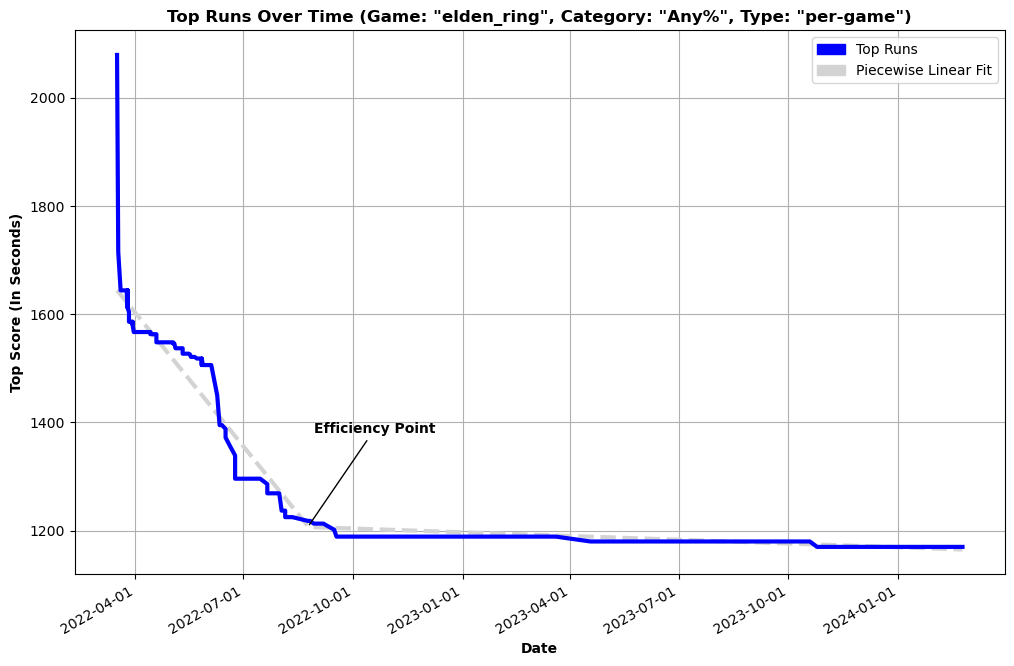

In [16]:
elbow_x, elbow_y, elbow_date = efficiency_graph(game_name, top_category, top_type, csv_df, my_pwlf)

### Exploratory Data Analysis on metrics

In [17]:
# Get the index of the elbow in the original data
elbow_index = np.abs(x - elbow_x).argmin()

# Calculate the number of runs to the efficiency point
runs_to_efficiency = elbow_index + 1  # add 1 because indexing starts at 0

# Calculate the percentage of runs complete at efficiency
pct_runs_complete_at_efficiency = (runs_to_efficiency / len(x)) * 100

# Calculate the number of days to the efficiency point
days_to_efficiency = (elbow_date - min(csv_df['Date'])).days

# Calculate the total number of days in the data
total_days = (max(csv_df['Date']) - min(csv_df['Date'])).days

# Calculate the percentage of days to efficiency out of total days
pct_days_to_efficiency = (days_to_efficiency / total_days) * 100

# Convert elbow_y to a float
elbow_y_float = float(elbow_y[0])

# Get the last row (the latest top score)
latest_top_score = csv_df.iloc[-1]['Top_Score']

In [18]:
# Print the information
print(f"Number of runs to efficiency point: {runs_to_efficiency}")
print(f"Total runs: {len(x)}")
print(f"Date of efficiency: {elbow_date.strftime('%Y-%m-%d')}")
print(f"Score at efficiency: {elbow_y_float:.2f}")
print(f"Latest Top Score: {latest_top_score:.2f}")
print(f"Percentage of runs complete at efficiency: {pct_runs_complete_at_efficiency:.2f}%")

# Print the information
print("")
print(f"Number of days to the efficiency point: {days_to_efficiency}")
print(f"Total number of days: {total_days}")
print(f"Percentage of days to efficiency: {pct_days_to_efficiency:.2f}%")

Number of runs to efficiency point: 232
Total runs: 268
Date of efficiency: 2022-08-24
Score at efficiency: 1206.78
Latest Top Score: 1170.00
Percentage of runs complete at efficiency: 86.57%

Number of days to the efficiency point: 160
Total number of days: 709
Percentage of days to efficiency: 22.57%


### Jackknife resampling to determine confidence level of efficiency

In [19]:
# Initialize a list to store the Jackknife efficiency points
jackknife_efficiency_points = []

# Perform Jackknife resampling
for i in range(len(x)):
    # Create a resampled dataset by leaving out one observation
    resampled_x = np.delete(x, i)
    resampled_y = np.delete(y, i)
    
    # Calculate the efficiency point for the resampled dataset
    my_pwlf = pwlf.PiecewiseLinFit(resampled_x, resampled_y)
    res = my_pwlf.fit(2)
    elbow_x = res[1]  # the change point in the piecewise linear fit
    
    # Append the resampled efficiency point to the list
    jackknife_efficiency_points.append(elbow_x)

    # Print progress
    if (i+1) % 100 == 0:
        print(f"Completed {i+1} Jackknife samples out of {len(x)} Total Runs")

# Convert the list to a numpy array
jackknife_efficiency_points = np.array(jackknife_efficiency_points)

# Calculate the 99% confidence interval
ci_lower = np.percentile(jackknife_efficiency_points, 0.5)
ci_upper = np.percentile(jackknife_efficiency_points, 99.5)

# Convert the confidence interval bounds from ordinal date to regular date
ci_lower_date = dt.datetime.fromordinal(int(ci_lower))
ci_upper_date = dt.datetime.fromordinal(int(ci_upper))

print(f"99% confidence interval for the efficiency point:")
print(f"Early Date: {ci_lower_date.strftime('%Y-%m-%d')}")
print(f"Late Date: {ci_upper_date.strftime('%Y-%m-%d')}")
print(f"Estimated Date of efficiency: {elbow_date.strftime('%Y-%m-%d')}")

Completed 100 Jackknife samples out of 268 Total Runs
Completed 200 Jackknife samples out of 268 Total Runs
99% confidence interval for the efficiency point:
Early Date: 2022-08-22
Late Date: 2022-08-25
Estimated Date of efficiency: 2022-08-24


### Graphing Jackknife Confidence Interval

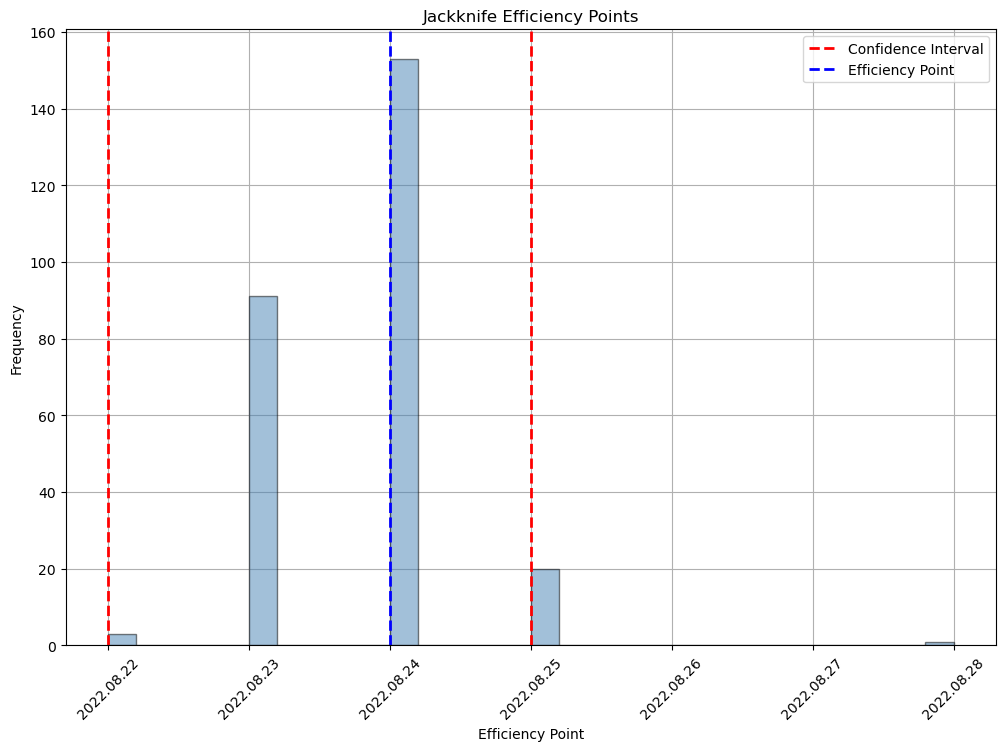

In [20]:
jackknife_efficiency_graph(jackknife_efficiency_points, ci_lower_date, ci_upper_date, elbow_date)